In [1]:
import sys
#needed for Google colab
!{sys.executable} -m pip install ipynb
import numpy as np
import torch
from torch import nn, distributions
from scipy.spatial.distance import cdist
from scipy.stats import norm
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
import scipy.io
import matlab.engine
eng = matlab.engine.start_matlab()
#eng.quit()

In [4]:
#import data

image_data_dict = scipy.io.loadmat('/home/cmau/PhD/RVoxM/no_sparsity_variant/oasis_healthy_down2.mat')
target_dict = scipy.io.loadmat('/home/cmau/PhD/RVoxM/no_sparsity_variant/oasis_target_healthy.mat')
#image_data_dict and target_dict are dictionaries

#arrays
target=np.squeeze(target_dict['target_healthy'])
image_data=image_data_dict['oasis_healthy_down2'] #image_data is a 4D array

In [5]:
#select train, validation and test set

[n_images,im_dim1,im_dim2,im_dim3]=np.shape(image_data)
#print(n_images)
#print(im_dim1)
#print(im_dim2)
#print(im_dim3)
n_test_images=50
rows_test=np.arange(n_test_images)
#print(rows_test)
n_valid_images=50;
rows_valid=np.arange(n_test_images,n_test_images+n_valid_images)
#print(rows_valid)
rows_train=np.setxor1d(np.arange(n_images), np.union1d(rows_test, rows_valid))
#print(rows_train)


#convert into matlab array

target_matlab=matlab.double(list(target)) #row vector
rows_valid_matlab=matlab.int32(list(rows_valid)) #row vector
rows_train_matlab=matlab.int32(list(rows_train)) #row vector



image_data_list=image_data.tolist()
image_data_matlab=matlab.double(image_data_list)




In [6]:
#definition of acquisition functions - code provided in the course

def probability_of_improvement(current_best, mean, std, xi):
   
    # since std coan be 0, to avoid an error, we add a small value in the denominator (like +1e-9)
    PI =  norm.cdf((mean - current_best - xi) / (std + 1e-9))
    return PI 


def expected_improvement(current_best, mean, std, xi):
    

    # start by computing the Z as we did in the probability of improvement function
    # to avoid division by 0, add a small term eg. np.spacing(1e6) to the denominator
    Z = (mean - current_best - xi) / (std + 1e-9) # or Z = (mean - current_best - eps) / (std + np.spacing(1e6))
    # now we have to compute the output only for the terms that have their std > 0
    EI = (mean - current_best - xi) * norm.cdf(Z) + std * norm.pdf(Z)
    EI[std == 0] = 0
    
    return EI


def GP_UCB(mean, std, t, dim = 1.0, v = 1.0, delta = .1):
    
    beta =  2 * np.log((t**( (dim/2) + 2) * np.pi**2 / 3 * delta) + 1e-9)
    UCB = mean + np.sqrt(v * beta) * std
    
    return UCB



def GP_UCB_approx(mean, std, t, eps):
    
    UCB = mean + eps * np.log(t) * std
    return UCB 




In [7]:


import GPy
#GPy.plotting.change_plotting_library('plotly')
from IPython.display import display





reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale


Optimization restart 1/10, f = 28.164365731183793
Optimization restart 2/10, f = 28.164365475008868
Optimization restart 3/10, f = 28.164365516388614
Optimization restart 4/10, f = 28.164366029446796
Optimization restart 5/10, f = 28.164383078676686
Optimization restart 6/10, f = 28.16436544888206
Optimization restart 7/10, f = 28.1643654161464
Optimization restart 8/10, f = 28.164365474544983
Optimization restart 9/10, f = 28.1643657981545
Optimization restart 10/10, f = 28.164365437643163


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.3304462346488553,+ve,
mul.Mat52.lengthscale,99.99420049260854,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.8422363482459441,+ve,
mul.Mat52_1.lengthscale,0.1316291046714553,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,1.589407823071185e-08,+ve,


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


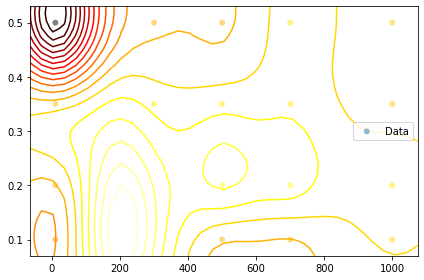

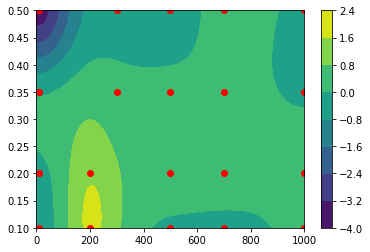

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning:The following kwargs were not used by contour: 'label'


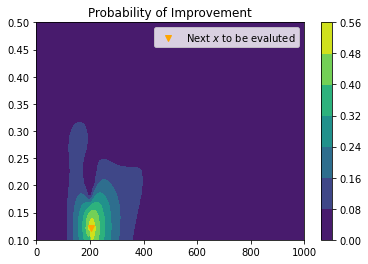

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning:The following kwargs were not used by contour: 'label'


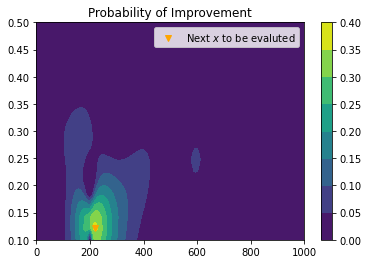

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning:The following kwargs were not used by contour: 'label'


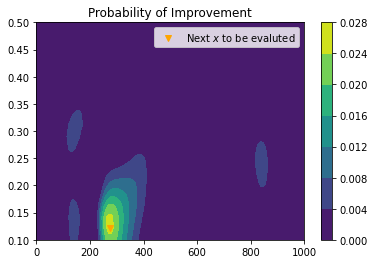

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning:The following kwargs were not used by contour: 'label'


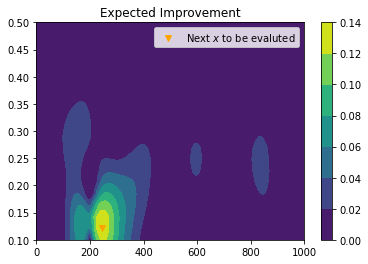

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning:The following kwargs were not used by contour: 'label'


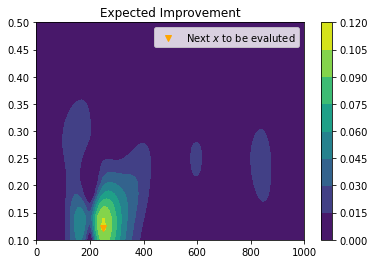

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning:The following kwargs were not used by contour: 'label'


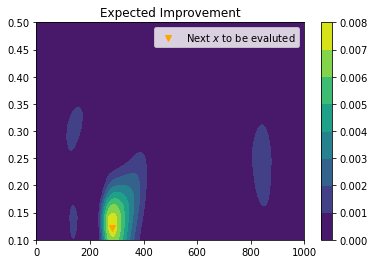

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning:The following kwargs were not used by contour: 'label'


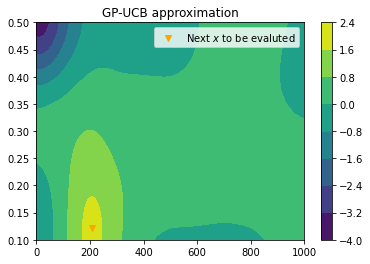

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning:The following kwargs were not used by contour: 'label'


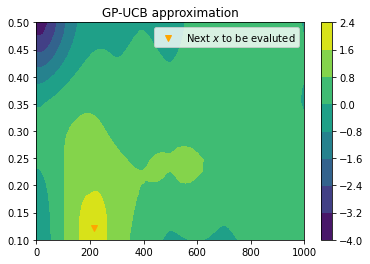

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:197: UserWarning:The following kwargs were not used by contour: 'label'


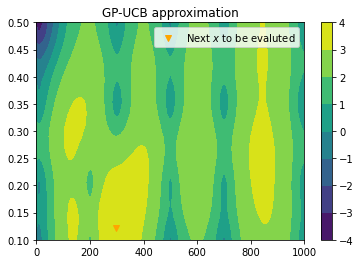

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning:The following kwargs were not used by contour: 'label'


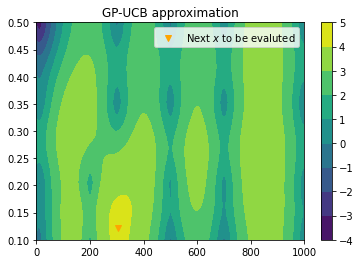

In [8]:
# EXEMPLE of fitting GPR and computing acquisition function

# space of interest 


n_l_points=1001
l_points = np.linspace(0,1000, n_l_points)
thresh_points = np.linspace(0.1,0.5,20)



Xv, Yv = np.meshgrid(l_points, thresh_points)
#Xv, Yv matrices with all x-cordinates and all y-cordiantes of the points in the grid
X1d=Xv.reshape(-1,1) #from matrix to column vector - reshape by rows
Y1d=Yv.reshape(-1,1)


Xtest = np.concatenate((X1d,Y1d),axis=1) #concatenate the two column vectors, by column, to obtain a Npoints x 2
                                #matrix with the coordinates of all the points of hte grid




#initial samples available

X_samples=[[10,0.1],[200,0.1],[500,0.1],[700,0.1],[1000,0.1],
            [10,0.2],[200,0.2],[500,0.2],[700,0.2],[1000,0.2],
                   [10,0.35],[300,0.35],[500,0.35],[700,0.35],[1000,0.35],
                   [10,0.5],[300,0.5],[500,0.5],[700,0.5],[1000,0.5]]


y_samples_init = [-6.399989391849354, -5.392877397065079, -6.241670138177358, -6.2666701536907805, -6.120046692908652, 
-6.276300461278821, -5.51831087349143, -5.867251668449377, -5.946421162818878, -6.064118899897121,
-6.209963786663207, -6.050415901572831, -6.05689776506659, -6.045060904569138, -6.184842641770987,
-7.746916157176965, -6.290309467591286, -6.289974847176011, -6.088624899027734, -6.180630934826991]

y_samples = (y_samples_init - np.mean(y_samples_init))/np.std(y_samples_init)


#choice of kernel
k1 = GPy.kern.Matern52(input_dim=1, active_dims=[0])
k2 =  GPy.kern.Matern52(input_dim=1, active_dims=[1])
#k1 = GPy.kern.RBF(input_dim=1, active_dims=[0])
#k2 =  GPy.kern.RBF(input_dim=1, active_dims=[1])

k1.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1))
k2.lengthscale.set_prior(GPy.priors.LogGaussian(-2, 0.6))


kernel = k1 * k2


X=np.array(X_samples)
Y=np.array(y_samples).reshape(-1,1)

#define GPR model
m = GPy.models.GPRegression(X,Y,kernel) 
                                    

#optimize GPR hyperparameters
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)
display(m)
fig = m.plot()
plt.show()
    


[mu, var] = m.predict(Xtest, full_cov=False)
std = np.sqrt(var)


#plot GPR mean
mu2d = mu.reshape(-1, n_l_points)
h = plt.contourf(l_points,thresh_points,mu2d)
plt.plot(X[:,0],X[:,1],'o', color='red')
#plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange')
plt.colorbar()
plt.show()




current_best = np.max(y_samples)
t = len(X) + 1 
## compute and plot different acquisition functions

## probability of improvement
acquisition_values1 = probability_of_improvement(current_best,  mu, std, 0.01)
acquisition_values2 = probability_of_improvement(current_best,  mu, std, 0.1)
acquisition_values3 = probability_of_improvement(current_best,  mu, std, 1)



z = acquisition_values1.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.01$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('Probability of Improvement')
plt.show()

z = acquisition_values2.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.1$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('Probability of Improvement')
plt.show()

z = acquisition_values3.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 1.$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.colorbar()
plt.legend()
plt.title('Probability of Improvement')
plt.show()




## expected_improvement
acquisition_values1 = expected_improvement(current_best,  mu, std, 0.01)
acquisition_values2 = expected_improvement(current_best,  mu, std, 0.1)
acquisition_values3 = expected_improvement(current_best,  mu, std, 1)

z = acquisition_values1.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.01$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('Expected Improvement')
plt.show()

z = acquisition_values2.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.1$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('Expected Improvement')
plt.show()

z = acquisition_values3.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 1.$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.colorbar()
plt.legend()
plt.title('Expected Improvement')
plt.show()





## GP-UCB approximate and no-regret
acquisition_values1 = GP_UCB_approx(mu, std, t, 0.01)
acquisition_values2 = GP_UCB_approx(mu, std, t, 0.1)
acquisition_values3 = GP_UCB_approx(mu, std, t, 1)
acquisition_values_no_regret = GP_UCB(mu, std, t)


z = acquisition_values1.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.01$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('GP-UCB approximation')
plt.show()

z = acquisition_values2.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 0.1$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.legend()
plt.colorbar()
plt.title('GP-UCB approximation')
plt.show()

z = acquisition_values3.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'$\xi = 1.$')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.colorbar()
plt.legend()
plt.title('GP-UCB approximation')
plt.show()

z = acquisition_values_no_regret.reshape(-1, n_l_points)
ind_max = np.where(z == np.max(z))
#ind_max[1][0]
plt.contourf(l_points,thresh_points,z, label =r'No-regret formulation')
plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
plt.colorbar()
plt.legend()
plt.title('GP-UCB approximation')
plt.show()




reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 28.674481915747712
Optimization restart 2/10, f = 28.674482008169242
Optimization restart 3/10, f = 28.674481917748395
Optimization restart 4/10, f = 28.67448202366578
Optimization restart 5/10, f = 28.674481961184846
Optimization restart 6/10, f = 28.674482020157487
Optimization restart 7/10, f = 28.674481921815893
Optimization restart 8/10, f = 28.67448201853714
Optimization restart 9/10, f = 28.67448204564328
Optimization restart 10/10, f = 28.67448192927705


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.0619693404576047,+ve,
mul.Mat52.lengthscale,99.99793626987586,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.0619693404576982,+ve,
mul.Mat52_1.lengthscale,0.12126942353292965,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.0001000223874741727,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


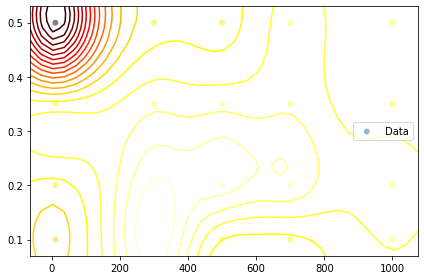

[377.0, 0.1631578947368421]


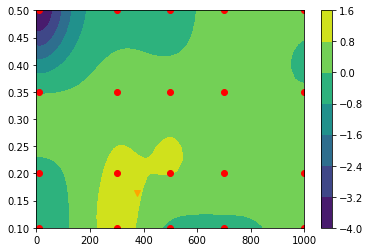

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


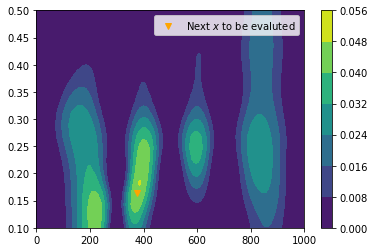

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 29.284472172801816
Optimization restart 2/10, f = 29.284472059719945
Optimization restart 3/10, f = 29.2844720935849
Optimization restart 4/10, f = 29.284472749815873
Optimization restart 5/10, f = 29.284472015477583
Optimization restart 6/10, f = 29.284472165715535
Optimization restart 7/10, f = 29.28447203210315
Optimization restart 8/10, f = 29.284476405074663
Optimization restart 9/10, f = 29.284472055070516
Optimization restart 10/10, f = 29.284472202282714


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.4891423125932255,+ve,
mul.Mat52.lengthscale,100.00672874926964,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.7107567617582622,+ve,
mul.Mat52_1.lengthscale,0.11825460731331204,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.0001000221013252784,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


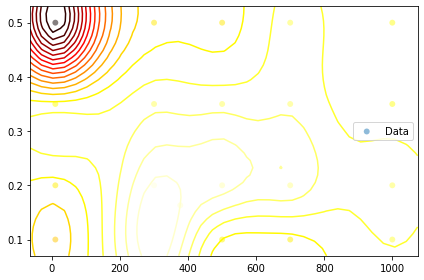

[216.0, 0.12105263157894737]


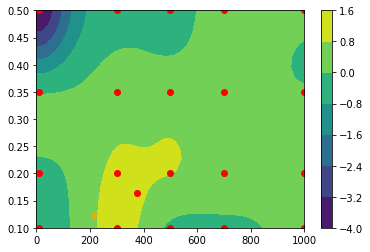

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


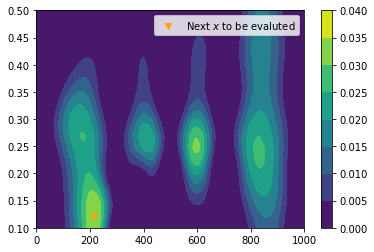

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 30.91320780837641
Optimization restart 2/10, f = 30.913207296175724
Optimization restart 3/10, f = 30.91321125762483
Optimization restart 4/10, f = 30.91320765392132
Optimization restart 5/10, f = 30.913207295616886
Optimization restart 6/10, f = 30.91320731735712
Optimization restart 7/10, f = 30.91320733520112
Optimization restart 8/10, f = 30.91320754955538
Optimization restart 9/10, f = 30.91321749802643
Optimization restart 10/10, f = 30.91320729667391


GP_regression.,value,constraints,priors
mul.Mat52.variance,2.4790317281682563,+ve,
mul.Mat52.lengthscale,100.01138971519424,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.4478625598623063,+ve,
mul.Mat52_1.lengthscale,0.11961417551856865,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010001758921360744,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


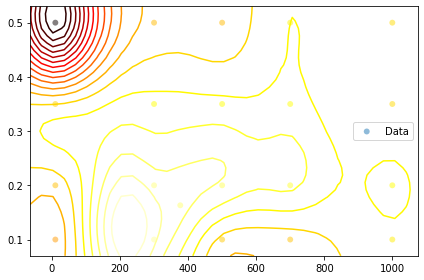

[179.0, 0.22631578947368422]


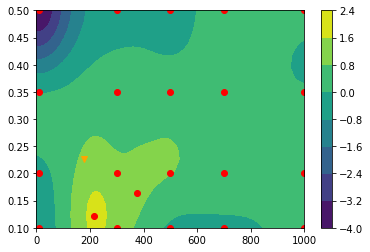

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


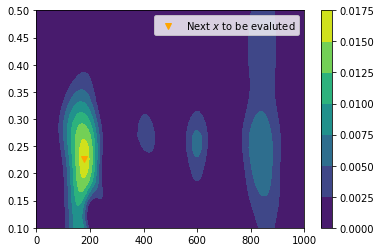

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 31.92767834323323
Optimization restart 2/10, f = 31.9276782452678
Optimization restart 3/10, f = 31.927678302912902
Optimization restart 4/10, f = 31.92767822365709
Optimization restart 5/10, f = 31.927678464755303
Optimization restart 6/10, f = 31.927678296078266
Optimization restart 7/10, f = 31.927679957136405
Optimization restart 8/10, f = 31.92767822361105
Optimization restart 9/10, f = 31.927679494105284
Optimization restart 10/10, f = 31.927678277778053


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.7191880736385015,+ve,
mul.Mat52.lengthscale,100.01576522546056,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.6668896791155795,+ve,
mul.Mat52_1.lengthscale,0.12934533288619326,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010001328252082365,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


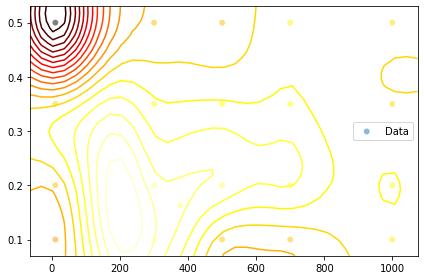

[154.0, 0.14210526315789473]


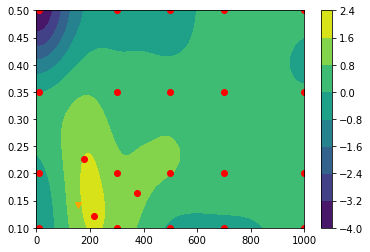

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


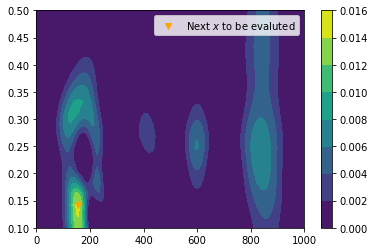

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 32.36865078729012
Optimization restart 2/10, f = 32.36864780555156
Optimization restart 3/10, f = 32.36865059488115
Optimization restart 4/10, f = 32.36864780351589
Optimization restart 5/10, f = 32.36864830716568
Optimization restart 6/10, f = 32.36864800958256
Optimization restart 7/10, f = 32.36864797327828
Optimization restart 8/10, f = 32.36864780311586
Optimization restart 9/10, f = 32.36864819573105
Optimization restart 10/10, f = 32.36864820731626


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.7199953880388092,+ve,
mul.Mat52.lengthscale,100.02587875549109,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.5379865143785982,+ve,
mul.Mat52_1.lengthscale,0.12894520958441263,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.0001000095359716822,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


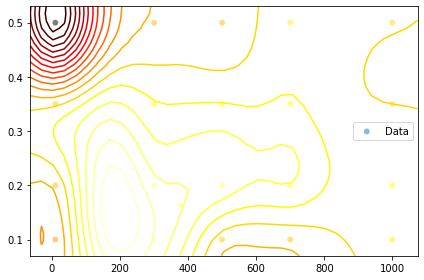

[131.0, 0.31052631578947365]


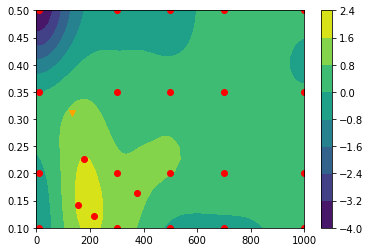

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


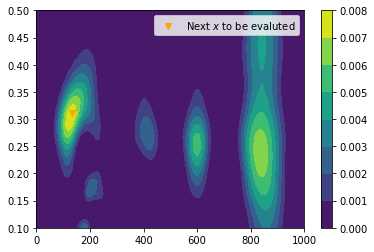

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 33.318774218646794
Optimization restart 2/10, f = 33.318774623561914
Optimization restart 3/10, f = 33.31877418857365
Optimization restart 4/10, f = 33.318774152547334
Optimization restart 5/10, f = 33.31877425356892
Optimization restart 6/10, f = 33.31877444747258
Optimization restart 7/10, f = 33.31877495506415
Optimization restart 8/10, f = 33.31877423894659
Optimization restart 9/10, f = 33.31877737534863
Optimization restart 10/10, f = 33.31877418037723


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.813533848429338,+ve,
mul.Mat52.lengthscale,100.03274802680868,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.3918609634248231,+ve,
mul.Mat52_1.lengthscale,0.1354693395189734,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.0001000056792261668,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


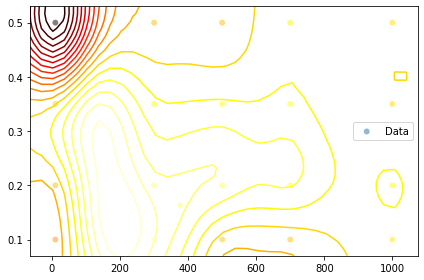

[836.0, 0.24736842105263157]


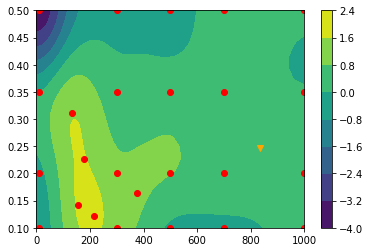

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


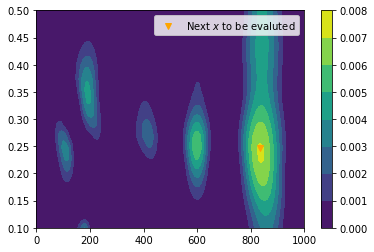

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 34.20216439870936
Optimization restart 2/10, f = 34.20216457476937
Optimization restart 3/10, f = 34.20216442920514
Optimization restart 4/10, f = 34.202164536629866
Optimization restart 5/10, f = 34.202164390884874
Optimization restart 6/10, f = 34.20216438263638
Optimization restart 7/10, f = 34.202164474604615
Optimization restart 8/10, f = 34.20216679250268
Optimization restart 9/10, f = 34.20216791804592
Optimization restart 10/10, f = 34.202164404903286


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.5026524656102913,+ve,
mul.Mat52.lengthscale,100.03586770367193,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,2.1347345164072973,+ve,
mul.Mat52_1.lengthscale,0.13253093461621362,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000553475997658,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


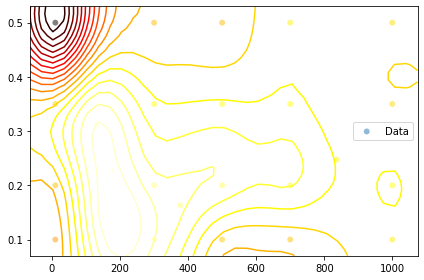

[598.0, 0.24736842105263157]


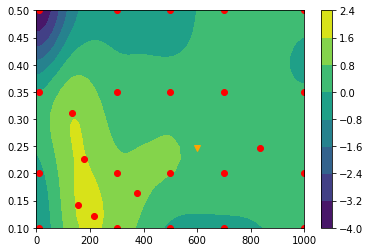

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


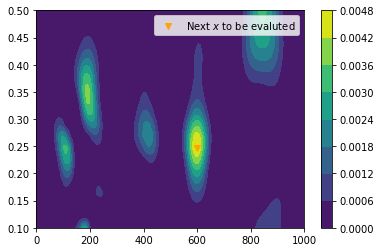

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 34.97022551453716
Optimization restart 2/10, f = 34.970228911789825
Optimization restart 3/10, f = 34.97022650692308
Optimization restart 4/10, f = 34.970225419477295
Optimization restart 5/10, f = 34.970225439934566
Optimization restart 6/10, f = 34.970232860812146
Optimization restart 7/10, f = 34.970230402021265
Optimization restart 8/10, f = 34.970225401777874
Optimization restart 9/10, f = 34.97022538870727
Optimization restart 10/10, f = 34.97022545092071


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.7918392890373169,+ve,
mul.Mat52.lengthscale,100.04510516319183,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.3124310459858117,+ve,
mul.Mat52_1.lengthscale,0.1316981705339935,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000585889978298,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


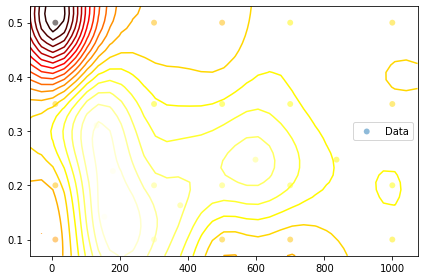

[190.0, 0.3526315789473684]


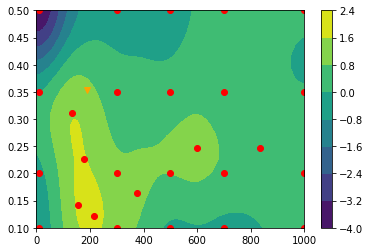

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


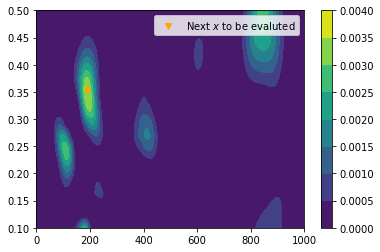

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 35.66126118685902
Optimization restart 2/10, f = 35.661254869974755
Optimization restart 3/10, f = 35.66125518894081
Optimization restart 4/10, f = 35.66126060512016
Optimization restart 5/10, f = 35.66125485194667
Optimization restart 6/10, f = 35.6612596024311
Optimization restart 7/10, f = 35.661254928907475
Optimization restart 8/10, f = 35.661255258848605
Optimization restart 9/10, f = 35.66125517606393
Optimization restart 10/10, f = 35.661255310242474


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.1921822672477025,+ve,
mul.Mat52.lengthscale,100.04706955744518,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.8566933068221319,+ve,
mul.Mat52_1.lengthscale,0.13108035150498792,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.0001000061390609329,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


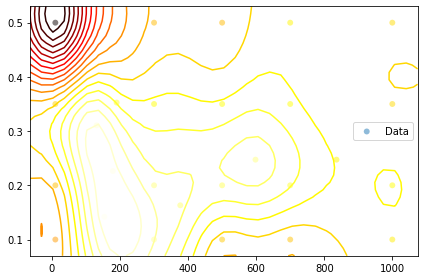

[106.0, 0.24736842105263157]


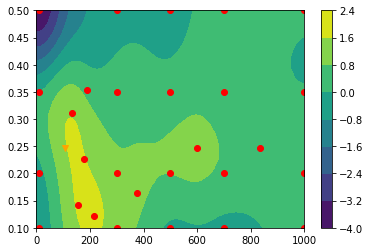

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


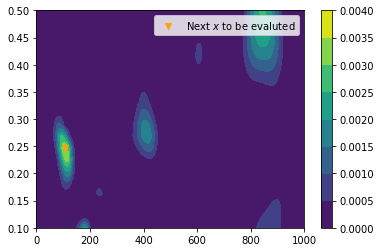

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 35.626512919654736
Optimization restart 2/10, f = 35.626512982938635
Optimization restart 3/10, f = 35.62651390971018
Optimization restart 4/10, f = 35.6265130809655
Optimization restart 5/10, f = 35.62651291701239
Optimization restart 6/10, f = 35.626514338405826
Optimization restart 7/10, f = 35.6265134638341
Optimization restart 8/10, f = 35.62651295726493
Optimization restart 9/10, f = 35.62651335303943
Optimization restart 10/10, f = 35.626512991344946


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.6249664405011334,+ve,
mul.Mat52.lengthscale,100.05841310211297,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.6046114609039646,+ve,
mul.Mat52_1.lengthscale,0.1344493616695398,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000265238408239,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


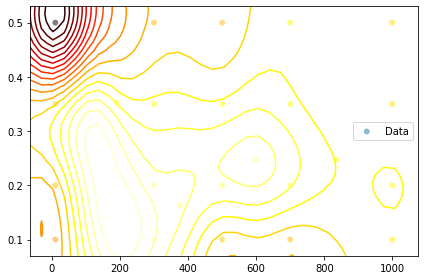

[844.0, 0.5]


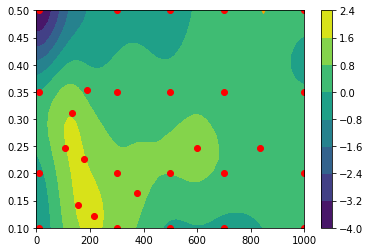

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


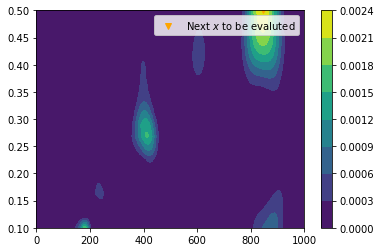

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 36.43818435040966
Optimization restart 2/10, f = 36.43818441412817
Optimization restart 3/10, f = 36.43818450727838
Optimization restart 4/10, f = 36.43818449017228
Optimization restart 5/10, f = 36.43818428834674
Optimization restart 6/10, f = 36.43818433568027
Optimization restart 7/10, f = 36.438184519569724
Optimization restart 8/10, f = 36.4381845655176
Optimization restart 9/10, f = 36.43818432801857
Optimization restart 10/10, f = 36.4381861230103


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.1275140183835748,+ve,
mul.Mat52.lengthscale,100.06156736413466,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.8515980894236943,+ve,
mul.Mat52_1.lengthscale,0.13249225470528164,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000379028103884,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


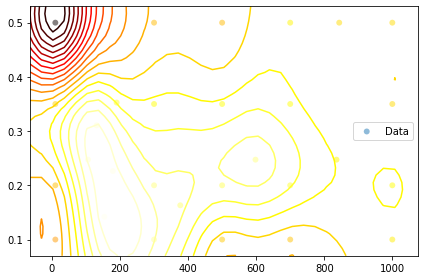

[180.0, 0.1]


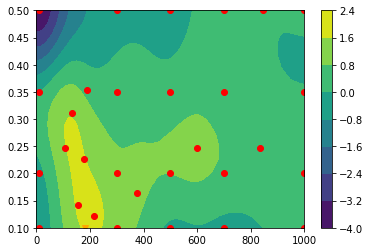

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


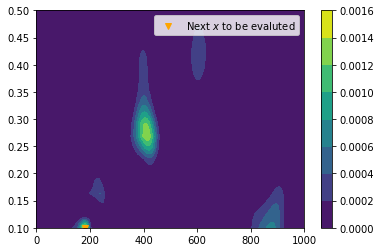

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 36.15715537018842
Optimization restart 2/10, f = 36.15715502314759
Optimization restart 3/10, f = 36.15715513815128
Optimization restart 4/10, f = 36.15715500416019
Optimization restart 5/10, f = 36.15715502999671
Optimization restart 6/10, f = 36.157155055531845
Optimization restart 7/10, f = 36.157155016906756
Optimization restart 8/10, f = 36.15715500144752
Optimization restart 9/10, f = 36.157155017200246
Optimization restart 10/10, f = 36.15715499634586


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.7456841865424979,+ve,
mul.Mat52.lengthscale,100.06850288318934,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.2916989344170011,+ve,
mul.Mat52_1.lengthscale,0.1383774739545081,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000191155520849,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


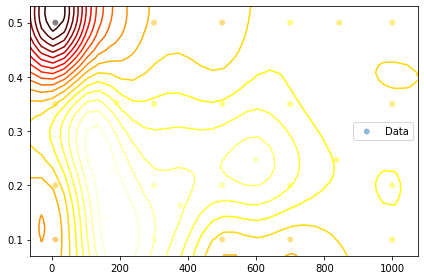

[413.0, 0.26842105263157895]


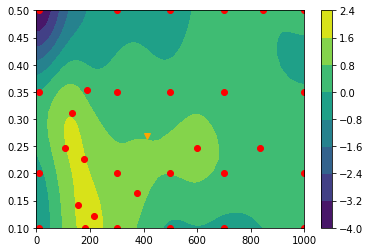

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


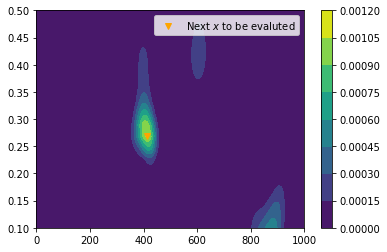

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 37.87176770244446
Optimization restart 2/10, f = 37.87176797633826
Optimization restart 3/10, f = 37.87176761307172
Optimization restart 4/10, f = 37.871767531030535
Optimization restart 5/10, f = 37.87176817061742
Optimization restart 6/10, f = 37.87176757780171
Optimization restart 7/10, f = 37.8717680709826
Optimization restart 8/10, f = 37.87176768923603
Optimization restart 9/10, f = 37.8717681891219
Optimization restart 10/10, f = 37.871767812388356


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.632352546145245,+ve,
mul.Mat52.lengthscale,100.06426257496608,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.6134974062049208,+ve,
mul.Mat52_1.lengthscale,0.13977489610142538,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000196362125993,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


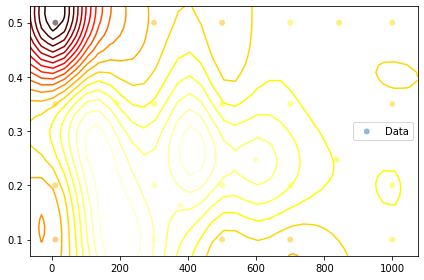

[398.0, 0.37368421052631584]


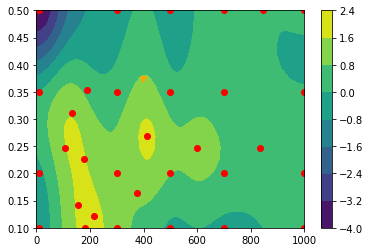

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


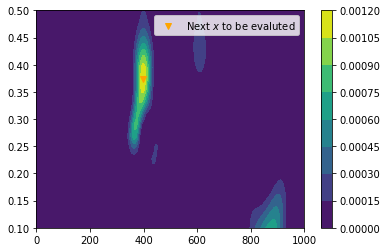

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 38.23432468830696
Optimization restart 2/10, f = 38.234324914174536
Optimization restart 3/10, f = 38.234323995937785
Optimization restart 4/10, f = 38.23432419207783
Optimization restart 5/10, f = 38.234323946562036
Optimization restart 6/10, f = 38.2343320586449
Optimization restart 7/10, f = 38.23432398059011
Optimization restart 8/10, f = 38.234323951241116
Optimization restart 9/10, f = 38.2343239929947
Optimization restart 10/10, f = 38.23436409184599


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.2338618157951613,+ve,
mul.Mat52.lengthscale,100.07124540784588,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.8083535643785386,+ve,
mul.Mat52_1.lengthscale,0.14128732377685277,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000146491646816,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


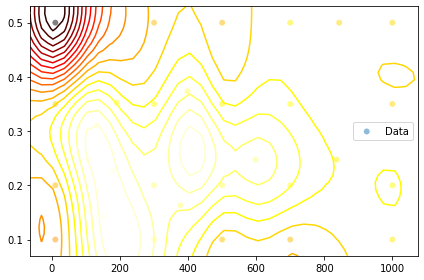

[880.0, 0.1]


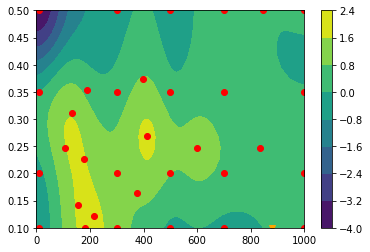

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


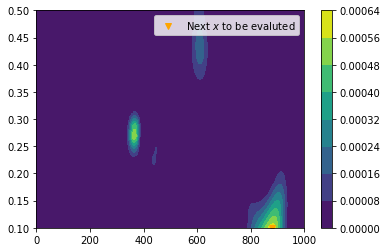

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 38.931199411894745
Optimization restart 2/10, f = 38.93119934273011
Optimization restart 3/10, f = 38.93119934122584
Optimization restart 4/10, f = 38.931199368356346
Optimization restart 5/10, f = 38.93120098431654
Optimization restart 6/10, f = 38.93119976884153
Optimization restart 7/10, f = 38.931200282313014
Optimization restart 8/10, f = 38.931199782069534
Optimization restart 9/10, f = 38.93120057309735
Optimization restart 10/10, f = 38.93119936319381


GP_regression.,value,constraints,priors
mul.Mat52.variance,1.247141805848393,+ve,
mul.Mat52.lengthscale,100.07542836713391,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.7739596595663646,+ve,
mul.Mat52_1.lengthscale,0.1406846944009703,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000171987181112,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


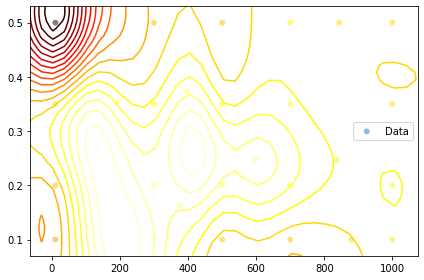

[365.0, 0.26842105263157895]


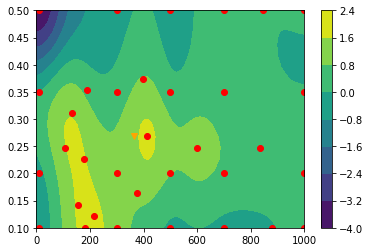

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


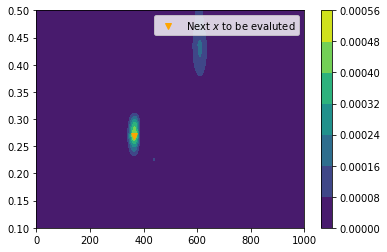

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 38.80228044410718
Optimization restart 2/10, f = 38.80228506360996
Optimization restart 3/10, f = 38.80228653427462
Optimization restart 4/10, f = 38.802280558155175
Optimization restart 5/10, f = 38.80228046297949
Optimization restart 6/10, f = 38.80228228540504
Optimization restart 7/10, f = 38.802281459706535
Optimization restart 8/10, f = 38.80228052560688
Optimization restart 9/10, f = 38.802280732028024
Optimization restart 10/10, f = 38.802281637706514


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.9760080321905442,+ve,
mul.Mat52.lengthscale,100.08305796623935,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,0.9760080321905935,+ve,
mul.Mat52_1.lengthscale,0.14304999727378792,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000165562500763,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


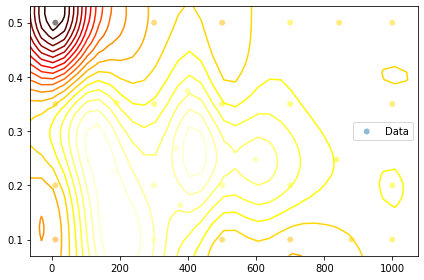

[610.0, 0.4368421052631579]


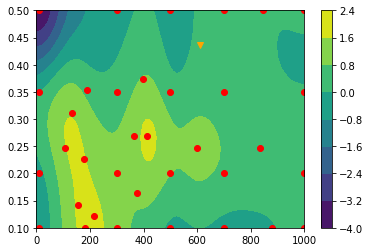

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


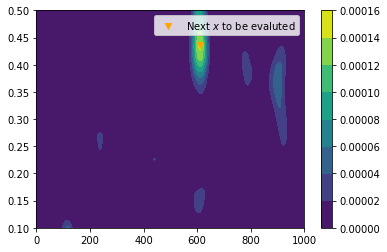

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 40.03082222534165
Optimization restart 2/10, f = 40.03082138937009
Optimization restart 3/10, f = 40.03082138222204
Optimization restart 4/10, f = 40.03082522338055
Optimization restart 5/10, f = 40.030822815679734
Optimization restart 6/10, f = 40.03082155984793
Optimization restart 7/10, f = 40.030821568575156
Optimization restart 8/10, f = 40.030822938875346
Optimization restart 9/10, f = 40.03082146444436
Optimization restart 10/10, f = 40.030821380093116


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.9089171205415598,+ve,
mul.Mat52.lengthscale,100.07468890363535,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.0759140899723298,+ve,
mul.Mat52_1.lengthscale,0.1460095697205302,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000151339006587,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


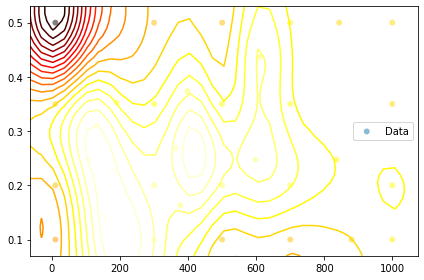

[902.0, 0.37368421052631584]


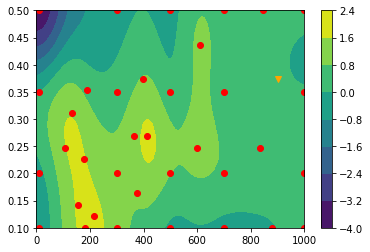

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


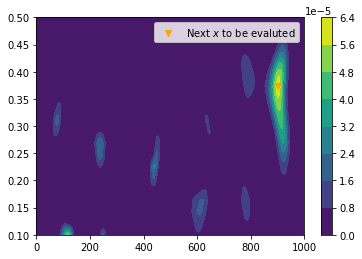

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/10, f = 41.09118287281929
Optimization restart 2/10, f = 41.09118182140543
Optimization restart 3/10, f = 41.09118378641134
Optimization restart 4/10, f = 41.09118200481309
Optimization restart 5/10, f = 41.09118439846676
Optimization restart 6/10, f = 41.09118178913929
Optimization restart 7/10, f = 41.09118235967996
Optimization restart 8/10, f = 41.09118197820442
Optimization restart 9/10, f = 41.09118239444762
Optimization restart 10/10, f = 41.09118226885396


GP_regression.,value,constraints,priors
mul.Mat52.variance,0.6342738032057601,+ve,
mul.Mat52.lengthscale,100.07283694843876,+ve,"Ga(1e+04, 1e+02)"
mul.Mat52_1.variance,1.545842380193175,+ve,
mul.Mat52_1.lengthscale,0.14607406976426737,+ve,"lnN(-2, 0.6)"
Gaussian_noise.variance,0.00010000150489598482,"0.0001,0.5",


 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


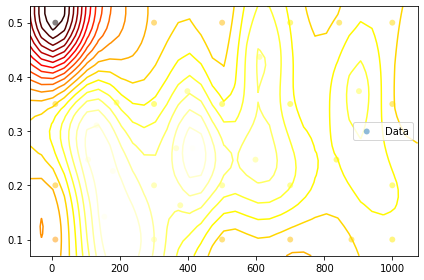

[116.0, 0.1]


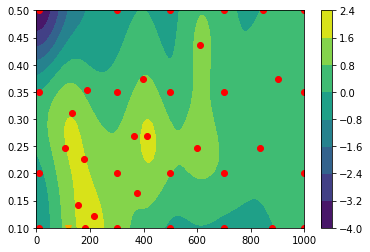

 /home/cmau/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning:The following kwargs were not used by contour: 'label'


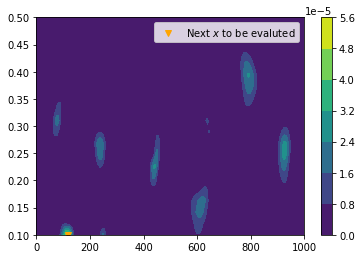


 Candidates for the maximum of the function are:
X's:  [[10, 0.1], [300, 0.1], [500, 0.1], [700, 0.1], [1000, 0.1], [10, 0.2], [300, 0.2], [500, 0.2], [700, 0.2], [1000, 0.2], [10, 0.35], [300, 0.35], [500, 0.35], [700, 0.35], [1000, 0.35], [10, 0.5], [300, 0.5], [500, 0.5], [700, 0.5], [1000, 0.5], [377.0, 0.1631578947368421], [216.0, 0.12105263157894737], [179.0, 0.22631578947368422], [154.0, 0.14210526315789473], [131.0, 0.31052631578947365], [836.0, 0.24736842105263157], [598.0, 0.24736842105263157], [190.0, 0.3526315789473684], [106.0, 0.24736842105263157], [844.0, 0.5], [180.0, 0.1], [413.0, 0.26842105263157895], [398.0, 0.37368421052631584], [880.0, 0.1], [365.0, 0.26842105263157895], [610.0, 0.4368421052631579], [902.0, 0.37368421052631584], [116.0, 0.1]]
Respective y's:  [-0.526652614658834, 1.2154971887072579, -0.1281824326163929, -0.1911044114765013, 0.17792889151387284, -0.21534271685457995, 1.031490736738333, 0.8141830240933781, 0.6149230976981893, 0.31869230054754333, -0

In [13]:
#BAYESIAN OPTIMIZATION

# array for the points x' and repective f(x') that we sample using the acquisition function
X_samples = []
y_samples = []

# number of iterations
T = 18

# number of initial random samples
init_samples = 20

# trade-off hyperparams
eps = 0.5


# space of interest 


n_l_points=1001

l_points = np.linspace(0,1000, n_l_points)
thresh_points = np.linspace(0.1,0.5,20)


Xv, Yv = np.meshgrid(l_points, thresh_points)
#Xv, Yv matrices with all x-cordinates and all y-cordiantes of the points in the grid
X1d=Xv.reshape(-1,1) #from matrix to column vector - reshape by rows
Y1d=Yv.reshape(-1,1)


Xtest = np.concatenate((X1d,Y1d),axis=1) #concatenate the two column vectors, by column, to obtain a Npoints x 2
                                #matrix with the coordinates of all the points of the grid


RMSES=[]
correlations=[]

#initial samples available

X_samples=[[10,0.1],[300,0.1],[500,0.1],[700,0.1],[1000,0.1],
            [10,0.2],[300,0.2],[500,0.2],[700,0.2],[1000,0.2],
                   [10,0.35],[300,0.35],[500,0.35],[700,0.35],[1000,0.35],
                   [10,0.5],[300,0.5],[500,0.5],[700,0.5],[1000,0.5]]




y_samples_init = [-6.399989391849354, -5.7078024501816405, -6.241670138177358, -6.2666701536907805, -6.120046692908652, 
-6.276300461278821, -5.780911469273687, -5.867251668449377, -5.946421162818878, -6.064118899897121,
-6.209963786663207, -6.050415901572831, -6.05689776506659, -6.045060904569138, -6.184842641770987,
-7.746916157176965, -6.290309467591286, -6.289974847176011, -6.088624899027734, -6.180630934826991]


y_samples = list((y_samples_init - np.mean(y_samples_init))/np.std(y_samples_init))
X=np.array(X_samples)
Y=np.array(y_samples).reshape(-1,1)    
    
#X_samples is a 2D list (list of lists)   
#X is a 2D array
    
    
# bayesian optimization loop

# compute the current best 
current_best = np.max(y_samples)


acquisition = 'improvement'
#acquisition = 'probability'
#acquisition = 'GP-UCB-approx'


for t in range(len(X),len(X) + T):
    
    #k52 = GPy.kern.Matern52(input_dim=2, variance=1, lengthscale=50)
    #k52.lengthscale.set_prior(GPy.priors.LogGaussian(-2, 0.6))
    #k52.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1))
    #k52.variance.set_prior(GPy.priors.Gamma.from_EV(1.,1.))


    
    #define kernel
    k1 = GPy.kern.Matern52(input_dim=1, active_dims=[0])
    k2 =  GPy.kern.Matern52(input_dim=1, active_dims=[1])
    #k1 = GPy.kern.RBF(input_dim=1, active_dims=[0])
    #k2 =  GPy.kern.RBF(input_dim=1, active_dims=[1])

    k1.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1))
    k2.lengthscale.set_prior(GPy.priors.LogGaussian(-2, 0.6))


    kernel = k1 * k2
    

    #define GPR model
    m = GPy.models.GPRegression(X,Y,kernel) 
    #m = GPy.models.GPRegression(X,Y,k52)                                     


    #constraint on noise variance
    m.Gaussian_noise.variance.constrain_bounded(0.0001,0.5)

    #optimization of GPR hyperparameters
    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 10)
    display(m)
    fig = m.plot()

    plt.show()
    
    #apply the fitted GPR model to the grid of points
    [mu, var] = m.predict(Xtest, full_cov=False)
    std = np.sqrt(var)

    #plt.plot(X_samples, y_samples, 'ro', label='Training points')
    #plt.gca().fill_between(xs.flat, mu.reshape(-1) - 2 * std.reshape(-1), mu.reshape(-1) + 2 * std.reshape(-1),  color='lightblue', alpha=0.5, label=r"$2\sigma$")
    #plt.plot(xs, mu, 'blue', label=r"$\mu$")
    #plt.xlim([-0.05,1.05])
    #plt.legend()
    #plt.show() 
    
    
    
      
    ## calculate acquisition values for your acquisition function of choice
    
    if acquisition == 'probability':
        acquisition_values = probability_of_improvement(current_best,  mu, std, eps)
        # print(acquisition_values)
    elif acquisition == 'improvement':
        acquisition_values = expected_improvement(current_best,  mu, std, eps)
    elif acquisition == 'GP-UCB-approx':
        acquisition_values = GP_UCB_approx(mu, std, t, eps)
    elif acquisition == 'GP-UCB-orig':
        acquisition_values = GP_UCB_original(mu, std, eps)
    else:
        assert acquisition == 'GP-UCB', "You have insert a wrong acquisition function"
        acquisition_values = GP_UCB(mu, std, t)
    
    # we have to find the point that maximizes this acquisition function
    z = acquisition_values.reshape(-1, n_l_points)
    ind_max = np.where(z == np.max(z))
    max_points=[l_points[ind_max[1][0]],thresh_points[ind_max[0][0]]]
    
    print(max_points)






    ## now we should create the plots
    if t > 0:
        
        #plot mean
        mu2d = mu.reshape(-1, n_l_points)
        h = plt.contourf(l_points,thresh_points,mu2d)
        plt.plot(X[:,0],X[:,1],'o', color='red')
        plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange')
       
        plt.colorbar()
        plt.show()
        
        
        
        #plot acquisition
        plt.contourf(l_points,thresh_points,z, label =r'acquisition function')
        plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange',label='Next $x$ to be evaluted')
        plt.legend()
        plt.colorbar()
        plt.show()


    
    #add new point to the samples
    X_samples.append(max_points)
    l_real=max_points[0];
    #train the machine learning model with the new set of hyperparameters, and get the validation performance
    [valid_correlation,valid_RMSE,valid_MAE,train_correlation,train_RMSE,train_MAE]=eng.performance_model(np.float(l_real),np.float(max_points[1]), image_data_matlab, target_matlab, rows_valid_matlab, rows_train_matlab, nargout=6)
    y_samples.append((-valid_MAE - np.mean(y_samples_init))/np.std(y_samples_init))
    #y_samples.append(-valid_MAE)
    RMSES.append(valid_RMSE)
    correlations.append(valid_correlation)
    X=np.array(X_samples)
    Y=np.array(y_samples).reshape(-1,1)
    
    

    # update current best
    current_best = np.max(y_samples)
    
    
  
    
print('\n Candidates for the maximum of the function are:')
print("X's: ", X_samples)
print("Respective y's: ", y_samples)
print('--------------')
print('The max of the function found by the algorithm is: ', np.max(y_samples))


In [88]:
#print maximum found by the BO algoirthm

max_found=np.max(y_samples)
max_found_orig=max_found*np.std(y_samples_init)+np.mean(y_samples_init)

print(max_found)
print(max_found_orig)
print(X_samples[np.argmax(y_samples)])
print(RMSES[np.argmax(y_samples)-init_samples])
print(correlations[np.argmax(y_samples)-init_samples])


1.8013323905039047
-5.475039759011565
7.34773267358728
0.9484448177267528


In [71]:
#apply model on the test set

rows_test_2=rows_test
rows_test_2[0]=n_images
rows_test_2=np.sort(rows_test_2)
print(rows_test_2)


final_l=X_samples[np.argmax(y_samples)][0]
final_thresh=X_samples[np.argmax(y_samples)][1]
rows_test_matlab=matlab.int32(list(rows_test_2)) #row vector
print(final_l, final_thresh)
print(X_samples[np.argmax(y_samples)])

[test_correlation,test_RMSE,test_MAE,train_correlation,train_RMSE,train_MAE]=eng.performance_model(np.float(final_l),np.float(final_thresh), image_data_matlab, target_matlab, rows_test_matlab, rows_train_matlab, nargout=6)
print(test_MAE,test_correlation,test_RMSE)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49 336]
180.0 0.1
[180.0, 0.1]
7.078185236968868


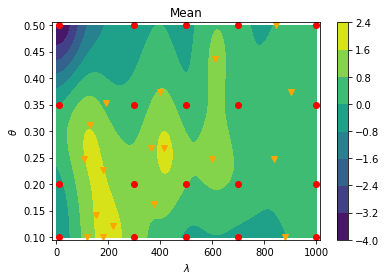

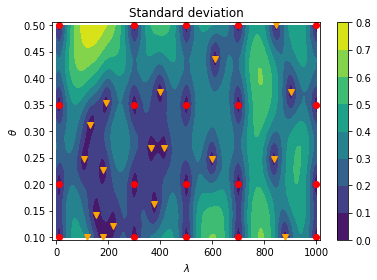

In [92]:
#plot final mean and std


#mu2d = mu.reshape(-1, n_l_points)
h = plt.contourf(l_points,thresh_points,mu2d)
#plt.plot(X[0:-1,0],X[0:-1,1],'o', color='red')
plt.plot(X[0:init_samples,0],X[0:init_samples,1],'o', color='red', label=r'Initial samples')
plt.plot(X[-T:,0],X[-T:,1],'v', color='orange',  label=r'Query points')
#plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange')
#plt.legend(Location)
plt.xlim([-15 ,1015]) 
plt.ylim([0.095,0.505])
plt.colorbar()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\theta$')
plt.title('Mean')
plt.show()


std2d = std.reshape(-1, n_l_points)
plt.contourf(l_points,thresh_points,std2d)
#plt.plot(X[0:-1,0],X[0:-1,1],'o', color='red')
plt.plot(X[0:init_samples,0],X[0:init_samples,1],'o', color='red')
plt.plot(X[-T:,0],X[-T:,1],'v', color='orange')
#plt.plot(l_points[ind_max[1][0]],thresh_points[ind_max[0][0]],'v', color='orange')
plt.xlim([-15 ,1015]) 
plt.ylim([0.095,0.505])
plt.colorbar()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\theta$')
plt.title('Standard deviation')
plt.show()

#print(np.min(std))

#print(X[0:-1,0])
#print(X[:,0])
#print(X[-T:,0])